In [1]:
#add mbes_sim to search path
import sys
sys.path.insert(0, "../../src/")

In [18]:
%matplotlib widget

from ipywidgets import *
import matplotlib.pyplot as plt

import numpy as np
import math
from copy import deepcopy
from tqdm.auto import tqdm

import mbes_sim.simulationfunctions as SIMFUN
import mbes_sim.functions.create_bubblesfunctions as bubbles
import themachinethatgoesping as theping

In [3]:
# simplify plotting
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 100
close_plots = True


def create_figure(name):
    if close_plots: plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name
    
    return fig

In [4]:
downfactor = 1 #speed up sumlation by reducing the resolution and number of beams and samples of the mbes
resfactor  = 1
voxsize    = 1

beam_pattern = SIMFUN.t_Window.Exponential

method_name = 'sv_int_lin'

In [5]:
setup = SIMFUN.SimulationSetup(
    addPlots = True,
    prefix = 'examples',
    downfactor = downfactor,
    blockAvg = False,
    resfactor  = resfactor,
    windowType           = beam_pattern,
    idealizedBeampattern = False,
    equiDist             = False,
    motionDataPath = '../../test_data/m143_l0154_motion.csv',
    
    surveyType           = SIMFUN.t_Survey.RealMotion,
    voxelsize            = voxsize / downfactor,
    voxelsizeZ           = voxsize / downfactor,
    surveyspeedKnots     = 3,
    swathdistance        = 0.8 / downfactor,
    layerDepths          = [],
    layerSizes           = [],
    bubbleType           = SIMFUN.t_Bubbles.BubbleStream,
    exagHPR              = 1,
    BaseDirectory        = 'GEOMAR_simresults',
    
    load_previous_simresults = False,    
    verbose = True)


  0%|          | 0/256 [00:00<?, ?it/s]

recalculated MBES
-108.25 108.25


In [6]:
sim_setup = deepcopy(setup)

sim_survey = sim_setup.get_survey()

sim_survey.setRandomOffsetX(sim_setup.SimSetup['voxelsize'])
sim_survey.setRandomOffsetY(sim_setup.SimSetup['voxelsize'])
sim_survey.setRandomOffsetZ(sim_setup.SimSetup['voxelsize'])
sim_survey.pitchs_degree+=0 # try adding pitch. It is interesting as it bends the bubble stream side lobes (but does not seem to have a negative effect on echo grid integration)
sim_survey.yaws_degree+=0

sim_setup.Simulation.setSurvey(sim_survey)

targets = bubbles.BubbleGenerator().generate_bubblestreams_within_cylindrical_section_along_path(
    start_x = -1.5,
    end_x = 1.5,
    min_range = 0,
    max_range = 130,
    min_beamsteeringangle = -90,
    max_beamsteeringangle = 90,
    min_y = 41,
    max_y = 43,
        zdist_list=[0.1])

if False:
    xbase=targets.x[int(len(targets)/2)]
    ybase=targets.y[int(len(targets)/2)]
    zbase=targets.z[int(len(targets)/2)]
    for i in range(len(targets)):
        targets.x[i] += (targets.z[i] - zbase)/1.1 - xbase
        targets.y[i] += (targets.z[i] - zbase)/1.12 - ybase

sim_setup.Simulation.setTargets(targets)

np.mean(targets.y)

np.float64(41.619019764069954)

  0%|          | 0/271 [00:00<?, ?it/s]

(271, 256, 383)003 108.00939130892094 -0.18951954798250678 1231 1231                         


/tmp/ipykernel_60762/689501760.py:5: RuntimeWarning: divide by zero encountered in log10
  images=10*np.log10(wcis)


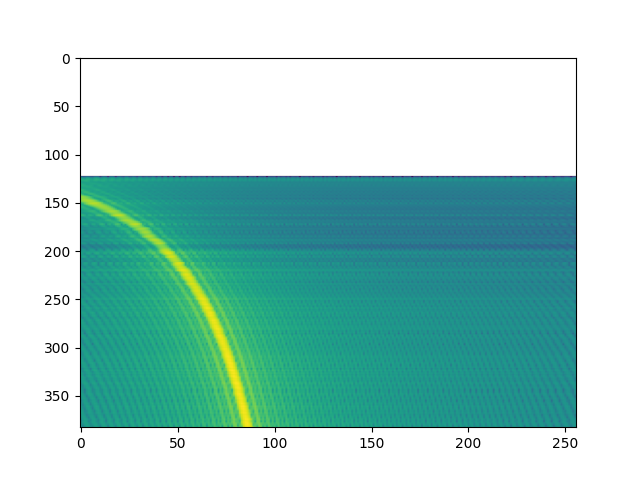

In [7]:
wcis = sim_setup.Simulation.simulateWCIs(progress=True)
print(wcis.shape)
plt.close('wcis')
fig,ax=plt.subplots(num='wcis')
images=10*np.log10(wcis)
ax.imshow(images[int(images.shape[0]/2)].transpose(),aspect='auto')

  0%|          | 0/271 [00:00<?, ?it/s]

124.76800000000003 108.00939130892094 -0.18951954798250678 1231 1231                         
(271, 256, 383)


/tmp/ipykernel_60762/1687566296.py:6: RuntimeWarning: divide by zero encountered in log10
  sv = 10*np.log10(SV)


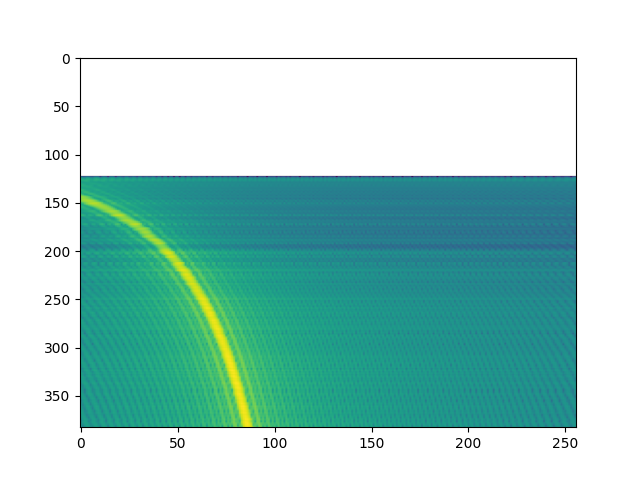

In [8]:
SV,X,Y,Z = sim_setup.Simulation.simulate3DEchoesSamples(progress=True)
print()
print(SV.shape)
plt.close('sv')
fig,ax=plt.subplots(num='sv')
sv = 10*np.log10(SV)
ax.imshow(sv[int(sv.shape[0]/2)].transpose(),aspect='auto')

In [12]:

import pyvista as pv
import numpy as np
from ipywidgets import interact, FloatSlider

# Assuming you have:
# x, y, z: coordinate arrays
# vals: value array for coloring
vals=10*np.log10(SV.flatten())
arg=np.where(np.isfinite(vals))
vals = vals[arg]
x=X.flatten()[arg]
y=Y.flatten()[arg]
z=-Z.flatten()[arg]   #default means z is positive down

# Assuming you have:
# x, y, z: coordinate arrays
# vals: value array for coloring

# Create point cloud data
points = np.column_stack((x, y, z))
point_cloud = pv.PolyData(points)
point_cloud.point_data['values'] = vals

# Get value range for slider
val_min = vals.min()
val_max = vals.max()
val_default = np.quantile(vals,0.95)

# Create plotter in notebook mode
plotter = pv.Plotter(notebook=True)

# Function to update threshold
def update_threshold(threshold):
    plotter.clear()
    
    # Apply threshold
    thresh = point_cloud.threshold(threshold, scalars='values')
    
    # Add points to plotter
    plotter.add_mesh(thresh,
                    render_points_as_spheres=True,
                    point_size=10,
                    scalars='values',
                    cmap='viridis',
                    clim=[val_min, val_max])
    
    plotter.add_scalar_bar('values')
    plotter.reset_camera()

# Create interactive widget
interact(update_threshold,
        threshold=FloatSlider(min=val_min,
                            max=val_max,
                            step=(val_max-val_min)/100,
                            value=val_default,
                            description='Threshold:',
                            continuous_update=True))

# Show the plot
plotter.show()

/tmp/ipykernel_60762/3624244808.py:8: RuntimeWarning: divide by zero encountered in log10
  vals=10*np.log10(SV.flatten())


interactive(children=(FloatSlider(value=-52.82813351755951, description='Threshold:', max=9.48856820443751, mi…

Widget(value='<iframe src="http://localhost:37965/index.html?ui=P_0x7e9d91d00290_1&reconnect=auto" class="pyvi…

In [15]:
plotter.clear()
plotter.close()

In [20]:
echogrid = sim_setup.Simulation.simulate3DEchoesGrid(progress=True)['weighted_mean']

  0%|          | 0/271 [00:00<?, ?it/s]

124.76800000000003 108.00939130892094 -0.18951954798250678 1231 1231                         

In [19]:
#better version

# SV,X,Y,Z = sim_setup.Simulation.simulate3DEchoesSamples(progress=True)

# #vals=10*np.log10(SV.flatten())
# vals=SV.flatten()
# if False:
#     arg=np.where(vals > 0)
# else:
#     arg=np.where(np.isfinite(vals))
# vals = vals[arg]
# x=X.flatten()[arg]
# y=Y.flatten()[arg]
# z=-Z.flatten()[arg]   #default means z is positive down

# echogrid = theping.gridding.EchoGrid.from_data(1.0, x,y,z,vals)

  0%|          | 0/271 [00:00<?, ?it/s]

124.76800000000003 108.00939130892094 -0.18951954798250678 1231 1231                         

AttributeError: type object 'EchoGrid' has no attribute 'from_data'

In [21]:
import numpy as np
import vtk
from vtk.util import numpy_support

def numpy_to_vtk_grid(values, x_coords, y_coords, z_coords):
    
    """Convert 3D numpy array with coordinates to VTK structured grid.
    
    Args:
        values (np.ndarray): 3D numpy array with values
        x_coords (np.ndarray): x coordinates
        y_coords (np.ndarray): y coordinates
        z_coords (np.ndarray): z coordinates
    
    Returns:
        vtk.vtkStructuredGrid: VTK grid with data
    """
    # Create the structured grid
    grid = vtk.vtkStructuredGrid()
    
    # Set dimensions
    grid.SetDimensions(len(x_coords), len(y_coords), len(z_coords))
    
    # Create points array
    points = vtk.vtkPoints()
    for z in z_coords:
        for y in y_coords:
            for x in x_coords:
                points.InsertNextPoint(x, y, z)
    
    # Set the points
    grid.SetPoints(points)
    
    # Add the data
    vtk_array = numpy_support.numpy_to_vtk(
        values.flatten(order='F'),
        deep=True,
        array_type=vtk.VTK_FLOAT
    )
    vtk_array.SetName("values")
    grid.GetPointData().AddArray(vtk_array)
    
    return grid

def echogrid_to_vtk(echogrid, min_db_val):
    values = echogrid.get_3DImage(minDbVal=min_db_val)
    gridder = echogrid.getGridder()
    
    x_coords = gridder.get_x_coordinates()
    y_coords = gridder.get_y_coordinates()
    z_coords = gridder.get_z_coordinates()

    return numpy_to_vtk_grid(values, x_coords, y_coords, z_coords)

In [23]:
echogrid.get_3DImage(

In [32]:
import pyvista as pv

min_db_val=-200

# Convert to VTK grid
print('create vtk')
echogrid.get_3DImage
image = echogrid.get_3DImage(mindBVal=min_db_val)
gridder = echogrid.getGridder()


vtk_grid = numpy_to_vtk_grid(
    image, 
    gridder.get_x_coordinates(),
    gridder.get_y_coordinates(),
    -np.array(gridder.get_z_coordinates()) #again: z definition is positve down, which maybe confusing in plotitng
)
pv_grid = pv.wrap(vtk_grid)


# Apply threshold to keep only finite values
if True:
    print('threshold')
    valid_range = np.nanmin(image), np.nanmax(image)
    print(valid_range)
    pv_grid = pv_grid.threshold(valid_range)

create vtk
threshold
(np.float64(-200.0), np.float64(6.226209143955024))


In [33]:
# Then you can convert to PyVista if needed:
import pyvista as pv

# Visualize
pl = pv.Plotter()
#pl = BackgroundPlotter()
pl.add_mesh(
    pv_grid,
    scalars='values',
    cmap="viridis",
    opacity=0.5,
    use_transparency=True,
    nan_opacity=0,
    
    #show_edges=False
)
pl.add_mesh_threshold(pv_grid,scalars='values',title='min_sv')
# def my_plane_func(normal, origin):
#     slc = pv_grid.slice(normal=normal, origin=origin)
#     arrows = slc.glyph(orient='vectors', scale="scalars", factor=0.01)
#     pl.add_mesh(arrows, name='arrows')
pl.add_mesh_slice(pv_grid,scalars='values')


# pl.add_plane_widget(my_plane_func)

pl.show_grid()
pl.show()

Widget(value='<iframe src="http://localhost:37965/index.html?ui=P_0x7e9d0dd53410_3&reconnect=auto" class="pyvi…